# Face Recognition with Eigenfaces

**Keywords**: Principal Component Analysis (PCA), Eigenvalues and Eigenvectors

**About the dataset**: \
[*Labeled Faces in the Wild*](http://vis-www.cs.umass.edu/lfw/) dataset consists of face photographs designed for studying the problem of unconstrained face recognition. The original dataset contains more than 13,000 images of faces collected from the web.

**Agenda**:
* In this programming challenge, we will be performing face recognition on the *Labeled Faces in the Wild* dataset using PyTorch. 
* First, we will do Principal Component Analysis (PCA) on the image dataset. PCA is used for dimentionality reduction which is a type of unsupervised learning.
* We will be applying PCA on the dataset to extract the principal components (Top $k$ *eigenvalues*). 
* As we will see eventually, the reconstruction of faces from these *eigenvalues* will give us the *eigen-faces* which are the most representative features of most of the images in the dataset. 
* Finally, we will train a simple PyTorch Neural Network model on the modified image dataset.
* This trained model will be used prediction and evaluation on a test set.



---



In [1]:
# loading the dataset directly from the scikit-learn library (can take about 3-5 mins)
import numpy as np
from sklearn.datasets import fetch_lfw_people
dataset = fetch_lfw_people(min_faces_per_person=80)

# each 2D image is of size 62 x 47 pixels, represented by a 2D array. 
# the value of each pixel is a real value from 0 to 255.
count, height, width = dataset.images.shape
print('The dataset type is:',type(dataset.images))
print('The number of images in the dataset:',count)
print('The height of each image:',height)
print('The width of each image:',width)

# sklearn also gives us a flattened version of the images which is a vector of size 62 x 47 = 2914.
# we can directly use that for our exercise
print('The shape of data is:',dataset.data.shape)

The dataset type is: <class 'numpy.ndarray'>
The number of images in the dataset: 1140
The height of each image: 62
The width of each image: 47
The shape of data is: (1140, 2914)


For optimum performance, we have only considered people who have more than 80 images. This restriction notably reduces the size of the dataset.\
Now let us look at the labels of the people present in the dataset

In [2]:
# create target label - target name pairs
targets = [(x,y) for x,y in zip(range(len(np.unique(dataset.target))), dataset.target_names)]
print('The target labels and names are:\n', targets)

The target labels and names are:
 [(0, 'Colin Powell'), (1, 'Donald Rumsfeld'), (2, 'George W Bush'), (3, 'Gerhard Schroeder'), (4, 'Tony Blair')]




---



### **(a) Preprocessing:** Using the `train_test_split` API from sklearn, we will split the data into train and test dataset in the ratio 3:1. Use `random_state=42`. 
### For better performance, it is recommended to normalize the features which can have different ranges with huge values. As all our features here are in the range [0,255],  it is not explicitly needed here. However, it is a good exercise. Use the `StandardScaler` class from sklearn and use that to normalize X_train and X_test. Validate and show your  result by printing the first 5 columns of 5 images of X_train (This result can vary from pc to pc). 

In [3]:
X = dataset.data 
y = dataset.target
print(X.shape)

(1140, 2914)


In [4]:
#######
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Splitting data into train(75%) and test(25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
# transform data using standard scaler
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

print("Normalized X_train values (5 rows and 5 columns)")
print(X_train[:5, :5])

# output variable names -  X_train, X_test, y_train, y_test
#######

Normalized X_train values (5 rows and 5 columns)
[[-0.9581398  -1.0216656  -1.0032063  -0.7196299  -0.5934948 ]
 [ 2.532961    2.3217816   1.5588257   0.75776595  0.2888807 ]
 [-1.07198    -1.0914823  -1.1301181  -0.9352498   1.2193854 ]
 [ 0.08919033 -0.02871611 -0.53521895 -1.1588557  -1.0747904 ]
 [ 0.02847559 -0.02871611 -0.08309564 -0.21651667 -0.07209121]]




---



### **(b) Dimentionality reduction** : In this section, we will use the `PCA` API from sklearn to extract the top 100 principal components of the image matrix and fit it on the training dataset. We can then visualize some of the top few components as an image (eigenfaces). 

In [5]:
#######
# initialize PCA API from sklearn with n_components. Also set svd_solver="randomized" and whiten=True in the initialization parameters.
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
n_components=100
pca = PCA(n_components=n_components,svd_solver="randomized",whiten=True)
#Fit the PCA model on training data
pca.fit(X_train)
# output variable name -  pca
#######

PCA(n_components=100, svd_solver='randomized', whiten=True)

### Now we will plot the most representative eigenfaces: 

In [6]:
# Helper function to plot
import matplotlib.pyplot as plt
def plot_gallery(images, titles, height, width, n_row=2, n_col=4):
    plt.figure(figsize=(2* n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

(100, 62, 47)


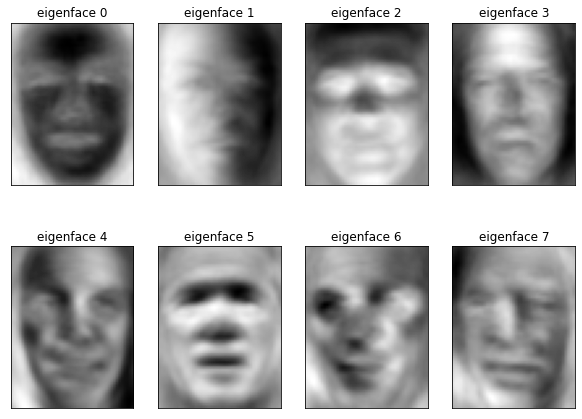

In [7]:
# get the 100 eigen faces and reshape them to original image size which is 62 x 47 pixels 
eigenfaces = pca.components_.reshape((n_components, height, width))
print(eigenfaces.shape)
# plot the top 8 eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, height, width)

plt.show()



---



### **(c) Face reconstruction:** In this section, we will reconstruct an image from its point projected on the principal component basis. Project the first three faces on the eigenvector basis using PCA models trained with varying number of principal components. Using the projected points, reconstruct the faces, and visualize  the images. Our final output should be a $3\times 5$ image matrix, where the rows are the data points, and the columns correspond to original image and reconstructed image for n_components$=[10,100,150,500]$. 

In [8]:
#eigenfaces = pca.components_
#print(eigenfaces.shape)
#print(X_train.shape)
#reconstructedImage = np.matmul(eigenfaces.T, np.matmul(eigenfaces,X_train[0]))
#print(reconstructedImage.shape)


(100, 2914)
(855, 2914)
(2914,)


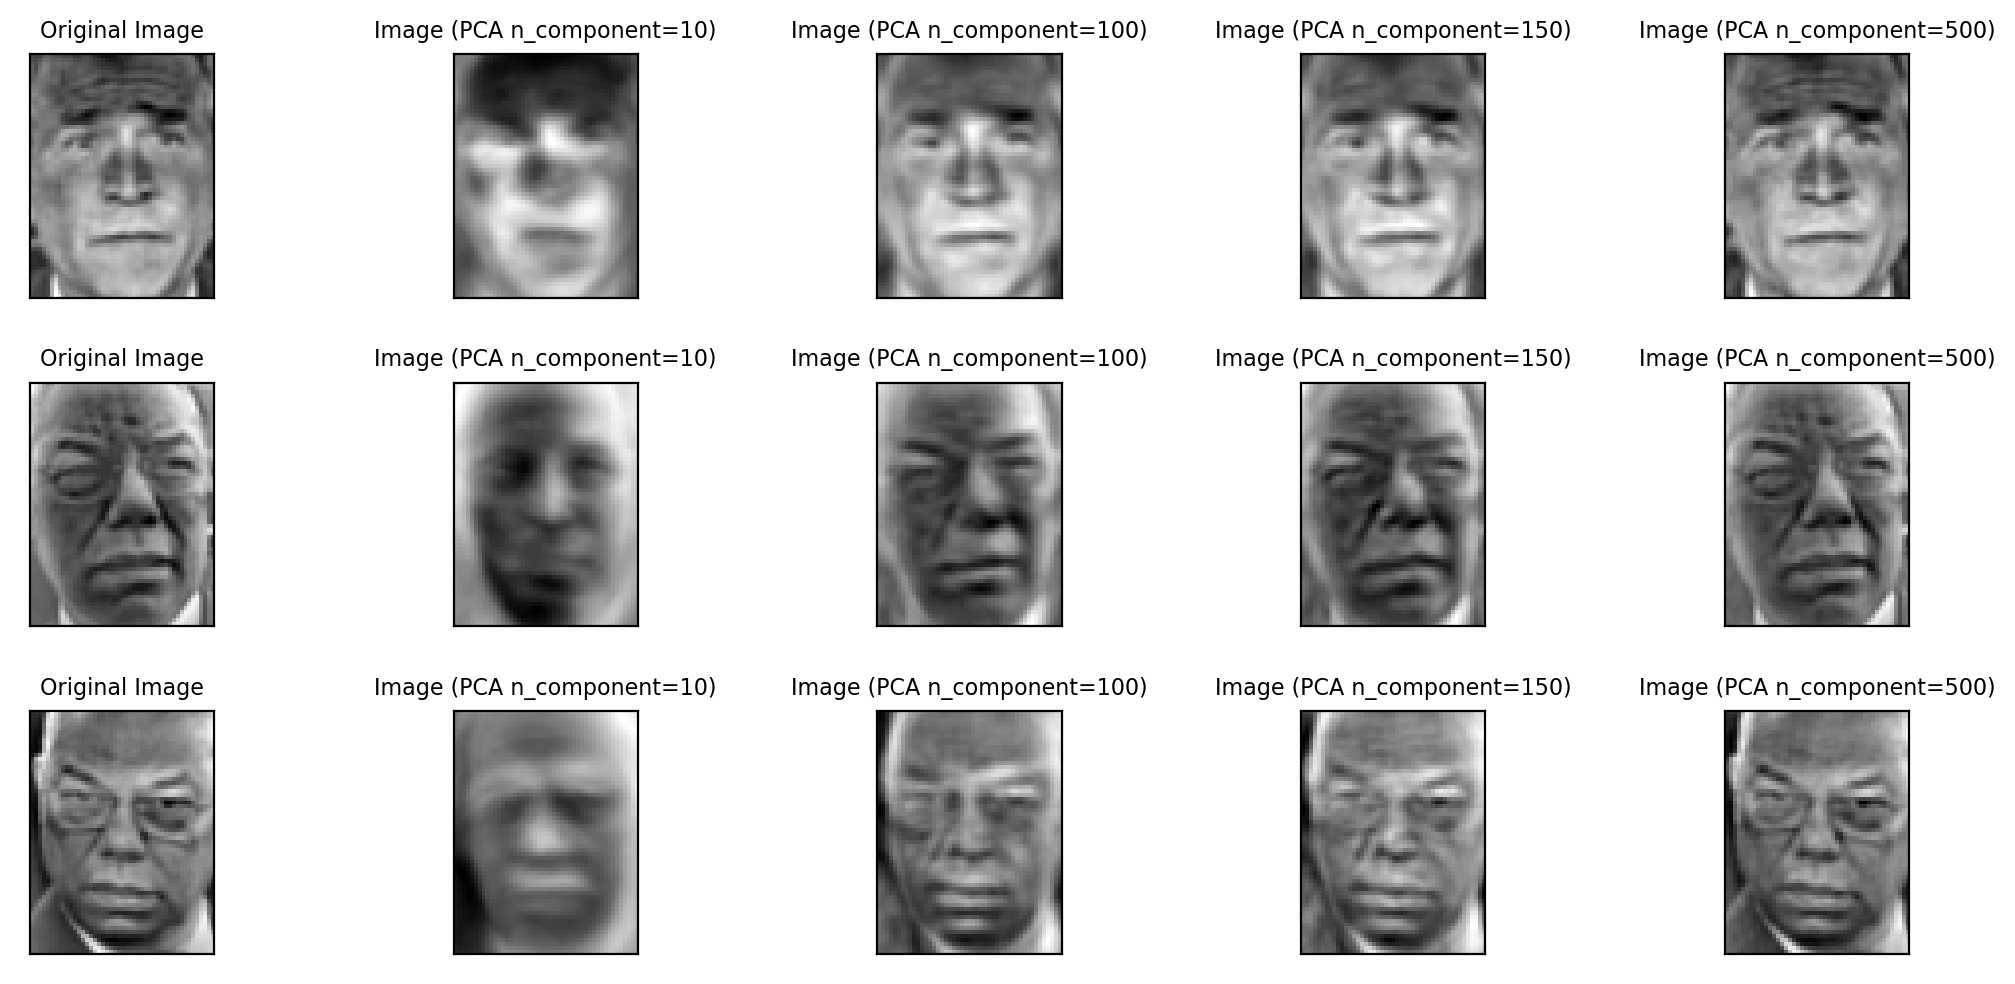

In [10]:
#Printing original images in 1st column
#The first column corresponds to subplot numbers 1,6 and 11 for a 3X5 image matrix
subplotNum = [1,6,11]
for i in range(3):
    #Setting subplot number
    plt.subplot(3,5,subplotNum[i])
    plt.subplots_adjust(wspace = 0.6)
    #Setting figure size and resolution
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['figure.dpi'] = 200
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    #Print image after reshaping the flattened X_train[i] into the shape of image (height=62 X width=47) pixels
    plt.imshow(X_train[i].reshape((height, width)), cmap=plt.cm.gray)
    #Set title of image
    plt.title("Original Image", size=8)
    plt.xticks(())
    plt.yticks(())


#Train PCA model for n_components=10
pca2 = PCA(n_components=10,svd_solver="randomized",whiten=True)
pca2.fit(X_train)
#Extract PCA components to reconstruct the image
eigenfaces = pca2.components_
subplotNum = [2,7,12]
for i in range(3):
    plt.subplot(3,5,subplotNum[i])
    plt.subplots_adjust(wspace = 0.6)
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    #Print image after calculating the projection of original image on the PCA component and then reshaping
    plt.imshow(np.matmul(eigenfaces.T, np.matmul(eigenfaces, X_train[i])).reshape((height, width)), cmap=plt.cm.gray)
    plt.title("Image (PCA n_component=10)", size=8)
    plt.xticks(())
    plt.yticks(())


#Train PCA model for n_components=100
pca3 = PCA(n_components=100,svd_solver="randomized",whiten=True)
pca3.fit(X_train)
eigenfaces_100 = pca3.components_
subplotNum = [3,8,13]
for i in range(3):
    plt.subplot(3,5,subplotNum[i])
    plt.imshow(np.matmul(eigenfaces_100.T, np.matmul(eigenfaces_100, X_train[i])).reshape((height, width)), cmap=plt.cm.gray)
    plt.title("Image (PCA n_component=100)", size=8)    
    plt.xticks(())
    plt.yticks(())

#Train PCA model for n_components=150
pca4 = PCA(n_components=150,svd_solver="randomized",whiten=True)
pca4.fit(X_train)
eigenfaces_150 = pca4.components_
subplotNum = [4,9,14]
for i in range(3):
    plt.subplot(3,5,subplotNum[i])
    plt.imshow(np.matmul(eigenfaces_150.T, np.matmul(eigenfaces_150, X_train[i])).reshape((height, width)), cmap=plt.cm.gray)
    plt.title("Image (PCA n_component=150)", size=8)    
    plt.xticks(())
    plt.yticks(())

#Train PCA model for n_components=500
pca5 = PCA(n_components=500,svd_solver="randomized",whiten=True)
pca5.fit(X_train)
eigenfaces_500 = pca5.components_
subplotNum = [5,10,15]
for i in range(3):
    plt.subplot(3,5,subplotNum[i])
    plt.imshow(np.matmul(eigenfaces_500.T, np.matmul(eigenfaces_500, X_train[i])).reshape((height, width)), cmap=plt.cm.gray)
    plt.title("Image (PCA n_component=500)", size=8)  
    plt.xticks(())
    plt.yticks(())

plt.show()



---



### **(d) Prediction:** In this section, we will train a neural network classifier in **PyTorch** on the transformed dataset. This classifier will help us with the face recognition task. 
### For PyTorch reference see [documentation](https://pytorch.org/docs/stable/index.html). 

In [11]:
# define imports here
import torch
import torch.nn as nn

### Before we start training, we need to transform the training and test dataset to reduced forms (100 dimensions) using the pca function defined in (b).
### we will also need to move the train and test dataset to torch tensors in order to work with pytorch.

In [12]:
#######
# 1. project X_train and X_test on orthonormal basis using the PCA API initialized in part (b). 
pca = PCA(n_components=100, svd_solver="randomized", whiten=True)
#Transforming train and test data using the pca model
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

# 2. now convert X_train_pca, X_test_pca, y_train and y_test to torch.tensor. For y_train and y_test, set dtype=torch.long
X_train_pca_torch = torch.from_numpy(X_train_pca)
X_test_pca_torch = torch.from_numpy(X_test_pca)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

# output variable names -  X_train_pca_torch, X_test_pca_torch, y_train_torch, y_test_torch
#######

In [13]:
#######
# 3. We will implement a simple multilayer perceptron (MLP) in pytorch with one hidden layer. 
# Using this neural network model, we will train on the transformed dataset.
class MLP(torch.nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    # Initalize various layers of MLP as instructed below
    # DO: initialze two linear layers: 100 -> 1024  and 1024-> 5
    self.firstLayer = nn.Linear(100,1024)
    self.secondLayer = nn.Linear(1024,5)
    # DO: initialize relu activation function
    self.relu = nn.ReLU()
    # DO: initialize LogSoftmax
    self.lsm = nn.LogSoftmax()
    
    
  def forward(self, x):
    # DO: define the feedforward algorithm of the model and return the final output
    #Passing input to the first linear layer
    firstLayerOutput = self.firstLayer(x)
    #Applying relu on the output of first layer
    relu = self.relu(firstLayerOutput)
    #Passing the relu output to the second linear layer
    secondLayerOutput = self.secondLayer(relu)
    #Passing the output of second layer to the logsoftmax activation function
    output = self.lsm(secondLayerOutput)
    return output

#######

In [17]:
#######
# 4. create an instance of the MLP class here
model = MLP()
# 5. define loss (use negative log likelihood loss: torch.nn.NLLLoss)
criterion = torch.nn.NLLLoss()
# 6. define optimizer (use torch.optim.SGD (Stochastic Gradient Descent)). 
# Set learning rate to 1e-1 and also set model parameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#######

# 7. train the classifier on the PCA-transformed training data for 500 epochs
# This part is already implemented.
# Go through each step carefully and understand what it does.
for epoch in range(501):
  # reset gradients
  optimizer.zero_grad()

  # predict
  output=model(X_train_pca_torch)

  # calculate loss
  loss=criterion(output, y_train_torch)

  # backpropagate loss
  loss.backward()

  # performs a single gradient update step
  optimizer.step()

  if epoch%50==0:
    print('Epoch: {}, Loss: {:.3f}'.format(epoch, loss.item()))

/var/folders/k0/4jn05k8x5m7bh0s5_5m44z980000gn/T/ipykernel_2891/4196244441.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.lsm(secondLayerOutput)


Epoch: 0, Loss: 1.624
Epoch: 50, Loss: 0.414
Epoch: 100, Loss: 0.207
Epoch: 150, Loss: 0.125
Epoch: 200, Loss: 0.084
Epoch: 250, Loss: 0.060
Epoch: 300, Loss: 0.046
Epoch: 350, Loss: 0.036
Epoch: 400, Loss: 0.030
Epoch: 450, Loss: 0.025
Epoch: 500, Loss: 0.021


In [18]:
# predict on test data
predictions = model(X_test_pca_torch) # gives softmax logits
y_pred = torch.argmax(predictions, dim=1).numpy() # get the labels from prdictions: nx5 -> nx1

/var/folders/k0/4jn05k8x5m7bh0s5_5m44z980000gn/T/ipykernel_2891/4196244441.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.lsm(secondLayerOutput)


                   precision    recall  f1-score   support

     Colin Powell       0.27      0.25      0.26        64
  Donald Rumsfeld       0.12      0.09      0.11        32
    George W Bush       0.46      0.57      0.51       127
Gerhard Schroeder       0.31      0.17      0.22        29
       Tony Blair       0.16      0.15      0.16        33

         accuracy                           0.35       285
        macro avg       0.27      0.25      0.25       285
     weighted avg       0.33      0.35      0.34       285



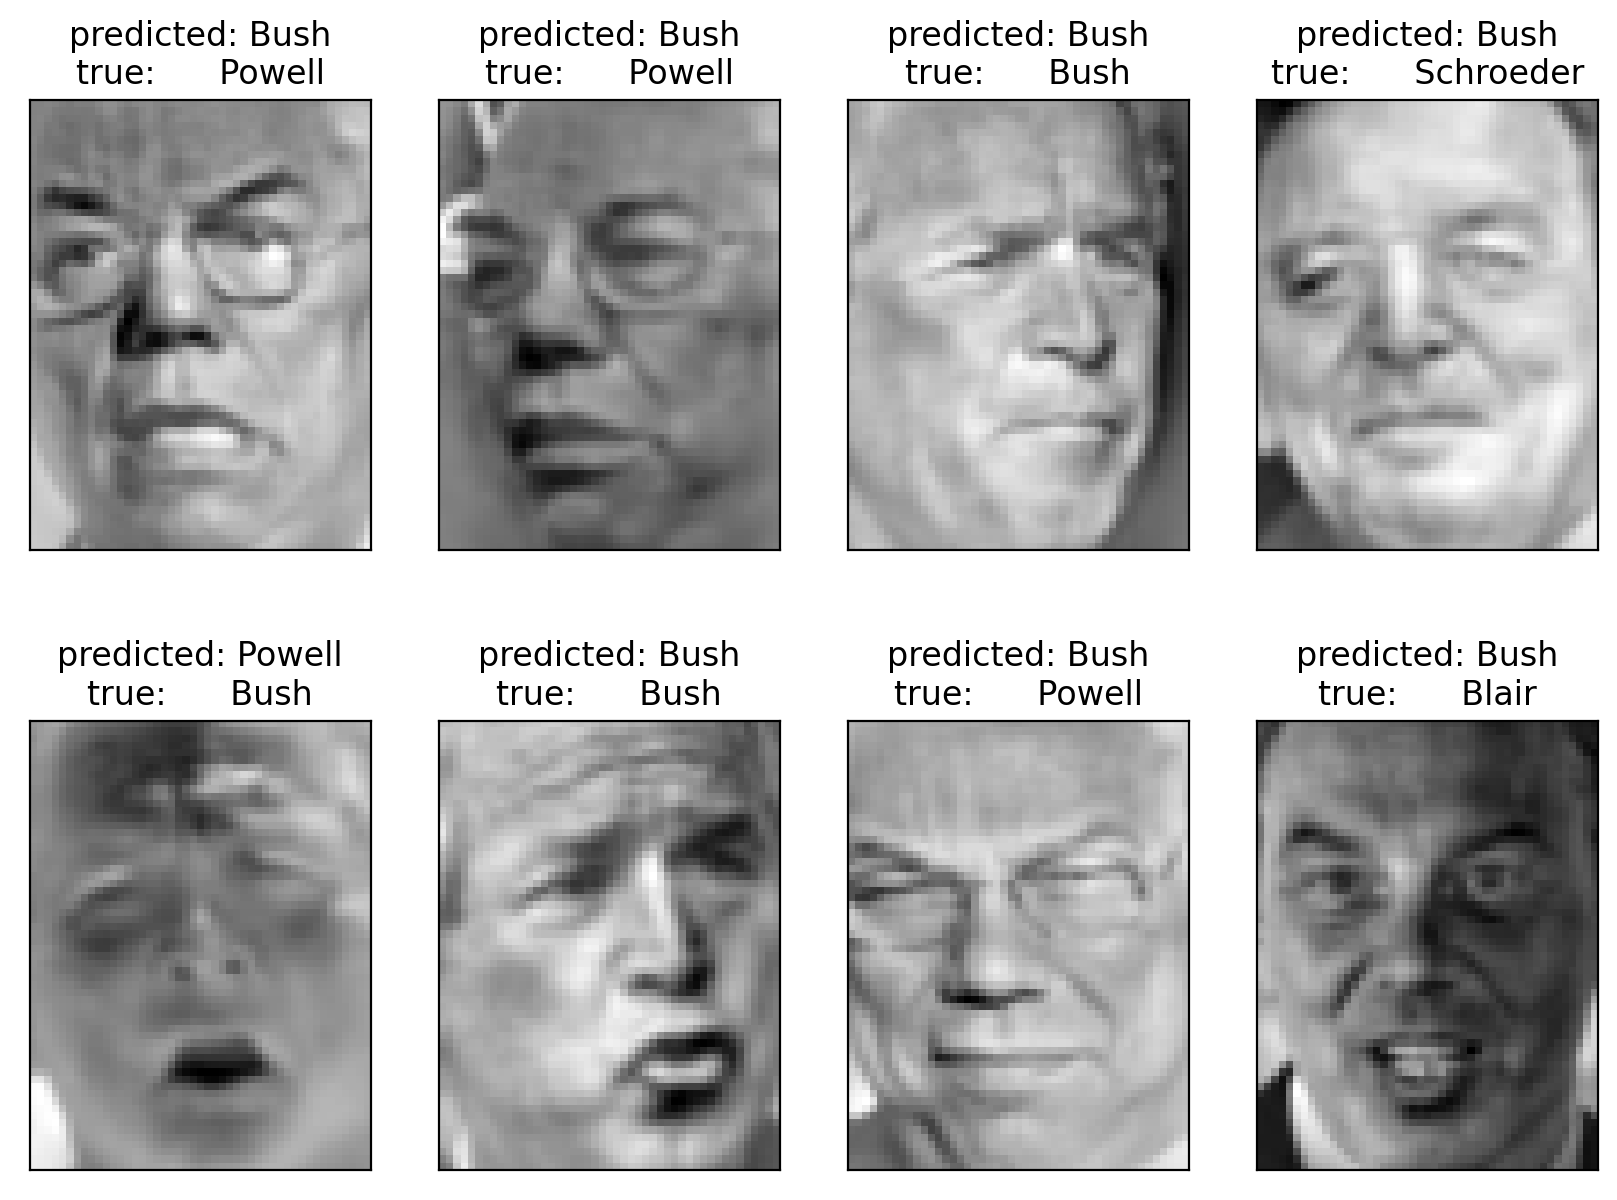

In [19]:
# here, we will print the multi-label classification report: precision, recall, f1-score etc.
from sklearn.metrics import classification_report
target_names=[y for x,y in targets]
print(classification_report(y_test, y_pred, target_names=target_names))

# let us validate some of the predictions by plotting images
# display some of the results
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)

prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, height, width)



---

